<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Voting-classifiers" data-toc-modified-id="1.-Voting-classifiers-1">1. Voting classifiers</a></span><ul class="toc-item"><li><span><a href="#1.1-Hard-voting-classifiers" data-toc-modified-id="1.1-Hard-voting-classifiers-1.1">1.1 Hard voting classifiers</a></span></li><li><span><a href="#1.2-Soft-voting-classifiers" data-toc-modified-id="1.2-Soft-voting-classifiers-1.2">1.2 Soft voting classifiers</a></span></li><li><span><a href="#1.3-VotingClassifier-with-GridSearchCV" data-toc-modified-id="1.3-VotingClassifier-with-GridSearchCV-1.3">1.3 <code>VotingClassifier</code> with <code>GridSearchCV</code></a></span></li></ul></li><li><span><a href="#2.-Voting-regression" data-toc-modified-id="2.-Voting-regression-2">2. Voting regression</a></span></li><li><span><a href="#3.-Bagging-meta-estimator" data-toc-modified-id="3.-Bagging-meta-estimator-3">3. Bagging meta-estimator</a></span><ul class="toc-item"><li><span><a href="#3.1-对比性能" data-toc-modified-id="3.1-对比性能-3.1">3.1 对比性能</a></span></li><li><span><a href="#3.2-Inspection" data-toc-modified-id="3.2-Inspection-3.2">3.2 Inspection</a></span></li><li><span><a href="#3.3-Out-of-Bag" data-toc-modified-id="3.3-Out-of-Bag-3.3">3.3 Out-of-Bag</a></span></li><li><span><a href="#3.4-Generation-error-=-Bias+Variance+Noise" data-toc-modified-id="3.4-Generation-error-=-Bias+Variance+Noise-3.4">3.4 Generation error = Bias+Variance+Noise</a></span></li></ul></li><li><span><a href="#4.-Forests-of-randomized-trees" data-toc-modified-id="4.-Forests-of-randomized-trees-4">4. Forests of randomized trees</a></span><ul class="toc-item"><li><span><a href="#4.1-Random-Forests" data-toc-modified-id="4.1-Random-Forests-4.1">4.1 Random Forests</a></span></li><li><span><a href="#4.2-Extremely-Randomized-Trees" data-toc-modified-id="4.2-Extremely-Randomized-Trees-4.2">4.2 Extremely Randomized Trees</a></span></li><li><span><a href="#4.3-参数（Parameters）" data-toc-modified-id="4.3-参数（Parameters）-4.3">4.3 参数（Parameters）</a></span></li><li><span><a href="#4.4-并行性（Parallelization）" data-toc-modified-id="4.4-并行性（Parallelization）-4.4">4.4 并行性（Parallelization）</a></span></li><li><span><a href="#4.5-（MDI）特征重要性（Feature-importance）" data-toc-modified-id="4.5-（MDI）特征重要性（Feature-importance）-4.5">4.5 （MDI）特征重要性（Feature importance）</a></span></li><li><span><a href="#4.6-排列特征重要性（Permutation-feature-importance）" data-toc-modified-id="4.6-排列特征重要性（Permutation-feature-importance）-4.6">4.6 <a href="https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance" target="_blank">排列特征重要性（Permutation feature importance）</a></a></span></li><li><span><a href="#4.7-Totally-Random-Trees-Embedding" data-toc-modified-id="4.7-Totally-Random-Trees-Embedding-4.7">4.7 Totally Random Trees Embedding</a></span></li></ul></li><li><span><a href="#5.-Boosting" data-toc-modified-id="5.-Boosting-5">5. Boosting</a></span><ul class="toc-item"><li><span><a href="#5.1-AdaBoost" data-toc-modified-id="5.1-AdaBoost-5.1">5.1 AdaBoost</a></span></li></ul></li></ul></div>

“三个臭皮匠，顶一个诸葛亮。” 这就是**群体智慧（wisdom of the crowd）**。

同样，如果 aggregate 一组（多个） predictor 的预测，通常会得到比最佳 predictor 更好的预测结果。

这样的一组（多个） predictor 称为 **ensemble**，这种技术称为 **Ensemble Learning**，一个 ensemble learning 算法称为 **Ensemble method**。

一个 ensemble method 的例子是，在训练集的不同随机子集（different random subset）上训练一组决策树分类器。在预测时，会得到每个决策树的预测结果，然后最终的输出预测结果是票数最多的 class。这样的关于决策树的 ensemble 称之为 **Random Forest**——虽然简单（simplicity），但最强大的机器学习算法之一。

在竞赛中，常胜算法通常涉及多种 ensemble method。

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn

from itertools import product
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score


%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

np.random.seed(42)
# Display all the estimator's all parameters when print estimator
# True: only display the non-default values
sklearn.set_config(print_changed_only=False)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

print('Version of Python:', sys.version)
print('Version of pandas:', pd.__version__)
print('Version of Scikit-Learn:', sklearn.__version__)

Version of Python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Version of pandas: 1.1.5
Version of Scikit-Learn: 0.24.2


# 1. Voting classifiers

<div class="alert alert-block alert-info">
    <b>voting classifiers 背后的思想是，聚合（aggregate）多个概念上不同（conceptually different）的分类算法，并且使用“少数服从多数”（hard voting）或者平均预测概率（soft voting）来输出预测类别。</b>这对于一组表现同样良好的模型来平衡他们各自的缺点是有用的。<br><br>
    <b>Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.</b>
</div>

## 1.1 Hard voting classifiers

假设已经训练好几个分类器了，每个分类器的 accuracy 在 80% 左右。

此时，要构建一个更佳的 classifier，最简单的做法是聚合（aggregate）每个 classifier 的预测结果，然后将得票最多的类别（class）作为预测类别。这种 majority-vote 分类器称之为**<font color='blue' size=1>hard voting classifier</font>**。

这个投票法分类器的 accuracy 通常要比该 ensemble 中的最佳分类器都要高。事实上，即使 ensemble 中的每个 classifier 都是**<font color='blue' size=1>弱学习器（weak learner）</font>——仅仅比随机猜测 random guessing 好一点**，通过 ensemble 也可以得到一个**<font color='blue' size=1>强学习器（strong learner）</font>——高 accuracy**，只要有数量足够多且类别足够多的弱学习器。

![train diverse classifers](chap07_figs/hard_voting_classifier_predictions.png)

假设有一个硬币，有 51% 的概率正面朝上，49% 的概率反面朝上。如果投掷 1000 次，大致会得到 ~510 次正面和 ~490 次反面，所以正面是大多数。

如果做数学的话，会发现，“在投掷 1000 次后，大多数为正面朝上”的概率接近 75%，并且投掷的次数越多，这个概率越高（投掷 10000 次后，这个概率会达到 97%）。这是因为 **大数定律（law of large numbers）** 导致的：随着不断地投掷该硬币，正面朝上的比例越来越接近于正面的概率(51%)。

In [2]:
# 大数定律（law of large numbers）

heads_proba = 0.51  # 正面朝上的概率
# 10次投掷实验，每次实验时正面朝上的累积次数
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# 正面朝上的概率
cumulative_heads_ratio = (np.cumsum(coin_tosses, axis=0)
                          / np.arange(1, 10001).reshape(-1, 1))

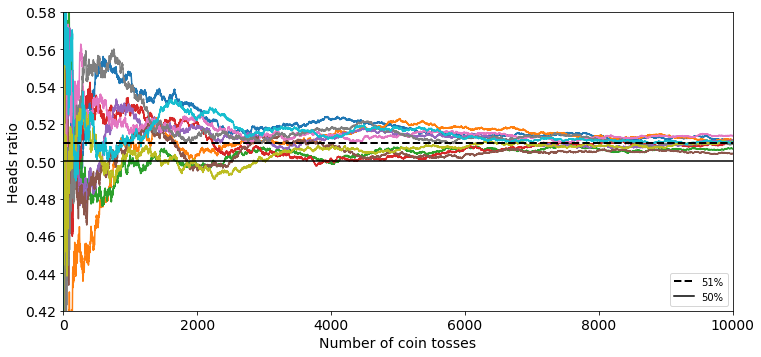

In [3]:
plt.figure(figsize=(12, 5.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', label='50%')
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

可以看到，随着投掷次数的增加，正面的比例逐渐接近 51%，最终所有的 10 条线（实验）全部接近 51%，并且始终位于 50% 以上。

同样，如果使用 1000 个 accuracy 约为 51% 的 classifier 来集成，并且以多数投票法的结果作为预测类别，可以达到 ~75% 的 accuracy。但前提是，所有的 classifier 都是完全独立的（perfectly independent）、彼此的错位类型都不同（make uncorrelated errors）。显然这是不可能的，因为他们都是在相同的训练集上训练的，很可能犯同样的错误（make same errors），这就导致“少数服从多数”的结果也是错误的，因此 ensemble 之后的 accuracy 降低。

**<font color='crimson'>当 predictor 尽可能相互独立时，集成方法的效果最优。获得多样的（diverse）的predictor 的一种方法是使用不同的算法进行训练。这会使得不同 predictor 犯不同错误的机会增加，从而提升集成的准确率。</font>**

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=500, noise=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_train.shape, x_test.shape

((375, 2), (125, 2))

In [5]:
y_train[:4]

array([1, 0, 0, 1])

In [6]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [7]:
# Train a HARD voting classifier
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    # List of (name_of_estimator, estimator)
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    # hard: majority rule voting
    voting='hard',
    # array-like of shape (n_classifiers,)
    # weight the occurrences of predicted class probabilities before averaging
    weights=None,  # use uniform weights
    n_jobs=-1,
    flatten_transform=True)
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [8]:
voting_clf.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degr

In [9]:
# type: Bunch
voting_clf.named_estimators_

{'lr': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'rf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 'svc': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_functio

In [10]:
# shape: (n_predictors,)
voting_clf.classes_

array([0, 1])

In [11]:
# voting='hard' 时，对于每个样本返回每个 estimator 的预测label
voting_clf.transform(x_train)

array([[1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 0]])

**在 `voting='hard'` 时，`predict_proba()` 不可用。**

In [12]:
# 每个 clf 的 accuracy
from sklearn.metrics import accuracy_score

for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    # Attention!
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


可以看到，voting 分类器的性能略胜于所有的单个分类器。

**如果各个 class 的票数相同，那么 `VotingClassifier` 将会选择第一个 class（所有的 class 按升序排）。**

- classifier 1 -> class 2

- classifier 2 -> class 1

- 结果是 class 1。

In [13]:
def plot_decision_boundary(x_train, y_train, x_test, y_test,
                           clfs, clf_names, figsize=(10, 6)):
    # for plot decision boundary
    x_min, x_max = x_train[:, 0].min() - 0.01, x_train[:, 0].max() + 0.01
    y_min, y_max = x_train[:, 1].min() - 0.01, x_train[:, 1].max() + 0.01
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    x_new = np.c_[xx.ravel(), yy.ravel()]

    f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=figsize)
    for idx, clf, clf_name in zip(product([0, 1], [0, 1]), clfs, clf_names):
        clf.fit(x_train, y_train)
        acc = accuracy_score(y_test, clf.predict(x_test))
        # for plot decision boundary
        y_pred = clf.predict(x_new).reshape(xx.shape)
        
        axarr[idx[0], idx[1]].contourf(
            xx, yy, y_pred, alpha=0.4, cmap=ListedColormap(['#a0faa0', '#9898ff']))
        # axarr[idx[0], idx[1]].scatter(
        #     x_train[:, 0], x_train[:, 1], c=y_train, s=20, edgecolor='k')
        axarr[idx[0], idx[1]].plot(
            x_train[:, 0][y_train == 0], x_train[:, 1][y_train == 0], 'go', ms=3)
        axarr[idx[0], idx[1]].plot(
            x_train[:, 0][y_train == 1], x_train[:, 1][y_train == 1], 'bs', ms=3)
        axarr[idx[0], idx[1]].set_title(
            "{}: acc={}".format(clf_name, acc), fontsize=14)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

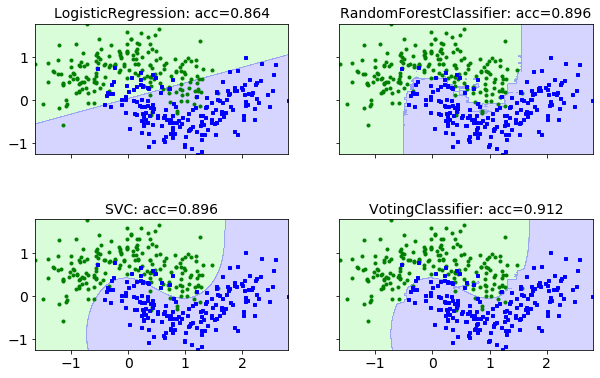

In [14]:
# Train a HARD voting classifier
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='hard')


clfs = [log_clf, rf_clf, svm_clf, voting_clf]
clf_names = [clf.__class__.__name__ for clf in clfs]
plot_decision_boundary(x_train, y_train, x_test, y_test, clfs, clf_names)

## 1.2 Soft voting classifiers

如果所有的分类器都能输出 class 的概率，即拥有 `predict_proba()` 方法，那么 Scikit-Learn (`voting='soft'`) 会在各个单分类器（individual classifier）上取平均，然后将平均概率最高的 class 作为预测结果。这称为**<font color='blue' size=1>soft voting</font>**。

通常，**<font color='crimson'>soft voting 比 hard voting 的性能更好，这是因为它会给予那些 highly confident 的分类器更高的权重</font>**。

> 需要在 `SVC` 设置 `probability=True` (default=False) 来使用概率估计。这会导致 SVC 使用 5-fold 的交叉验证，这会减慢训练速度，并且 `predict_proba()` 的结果可能与 `predict()` 不一致。

**例子：** 假设有 3 个分类器，并且任务是 3 分类（即有 3 个 class），并且所有分类器的权重相同（$w_1=w_2=w_3=1$）。


|**classifier**|**class1**|**class2**|**class3**|
|:--- | :---: | :---: | :----: |
|**分类器1**|$w_1*0.2$|$w_1*0.5$|$w_1*0.3$|
|**分类器2**|$w_2*0.6$|$w_2*0.3$|$w_2*0.1$|
|**分类器3**|$w_3*0.3$|$w_3*0.4$|$w3**0.3$|
|**加权平均值**|0.37|0.4|0.23|

这里，预测结果是 class2，因为它的加权平均值最大。

In [15]:
# Train a SOFT voting classifier
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    # soft: the argmax of the sums of the predicted probabilities
    voting='soft',
    # array-like of shape (n_classifiers,)
    # weight the occurrences of predicted class probabilities before averaging
    weights=None,
    n_jobs=-1,
    flatten_transform=True)
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [16]:
voting_clf.predict_proba(x_train)[:10]

array([[0.18728182, 0.81271818],
       [0.71333466, 0.28666534],
       [0.98723777, 0.01276223],
       [0.01705029, 0.98294971],
       [0.04469111, 0.95530889],
       [0.0850289 , 0.9149711 ],
       [0.51447858, 0.48552142],
       [0.15683025, 0.84316975],
       [0.97194921, 0.02805079],
       [0.75253223, 0.24746777]])

In [17]:
# voting='soft` 并且 flatten_transform=True 时，
# 为每个样本返回每个 estimator 对于每个 class 的预测概率
# shape: (n_samples, n_classifiers*n_classes)
voting_clf.transform(x_train)[:10]

array([[0.20878103, 0.79121897, 0.16      , 0.84      , 0.19306443,
        0.80693557],
       [0.61606627, 0.38393373, 0.9       , 0.1       , 0.6239377 ,
        0.3760623 ],
       [0.99492653, 0.00507347, 1.        , 0.        , 0.96678678,
        0.03321322],
       [0.02481244, 0.97518756, 0.        , 1.        , 0.02633842,
        0.97366158],
       [0.05772364, 0.94227636, 0.02      , 0.98      , 0.05634969,
        0.94365031],
       [0.22538408, 0.77461592, 0.02      , 0.98      , 0.00970262,
        0.99029738],
       [0.21822607, 0.78177393, 0.74      , 0.26      , 0.58520966,
        0.41479034],
       [0.43227102, 0.56772898, 0.01      , 0.99      , 0.02821975,
        0.97178025],
       [0.93207827, 0.06792173, 1.        , 0.        , 0.98376937,
        0.01623063],
       [0.38536915, 0.61463085, 0.98      , 0.02      , 0.89222753,
        0.10777247]])

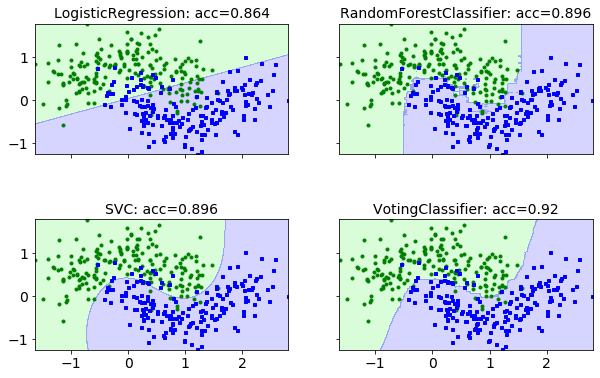

In [18]:
# Train a SOFT voting classifier
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='soft')


clfs = [log_clf, rf_clf, svm_clf, voting_clf]
clf_names = [clf.__class__.__name__ for clf in clfs]
plot_decision_boundary(x_train, y_train, x_test, y_test, clfs, clf_names)

## 1.3 `VotingClassifier` with `GridSearchCV`

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting='soft')


params = {'lr__C': [1, 10, 100], 'rf__n_estimators': [20, 100]}
grid_search = GridSearchCV(estimator=voting_clf, param_grid=params, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                              

In [21]:
grid_search.best_params_

{'lr__C': 1, 'rf__n_estimators': 100}

In [22]:
y_pred = grid_search.predict(x_test)
accuracy_score(y_test, y_pred)

0.92

# 2. Voting regression

<div class="alert alert-block alert-info">
    <b><code>VotingRegression</code> 背后的思想是，聚合（aggregate）多个概念上不同（conceptually different）的回归算法，并返回各个算法预测值的平均。</b><br><br>
    <b>Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses.</b>
</div>

In [23]:
from sklearn.datasets import load_diabetes

x_reg, y_reg = load_diabetes(return_X_y=True)
x_reg.shape, y_reg.shape

((442, 10), (442,))

In [24]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Initialization
gb_reg = GradientBoostingRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)
lr_reg = LinearRegression()
voting_reg = VotingRegressor(  # No param `voting`
    estimators=[('gb', gb_reg), ('rf', rf_reg), ('lr', lr_reg)],
    weights=None,
    n_jobs=-1)

# Train
gb_reg.fit(x_reg, y_reg)
rf_reg.fit(x_reg, y_reg)
lr_reg.fit(x_reg, y_reg)
voting_reg.fit(x_reg, y_reg)

# Predict
x_new, y_new = x_reg[:20], y_reg[:20]
y_pred_gb = gb_reg.predict(x_new)
y_pred_rf = rf_reg.predict(x_new)
y_pred_lr = lr_reg.predict(x_new)
y_pred_voting = voting_reg.predict(x_new)

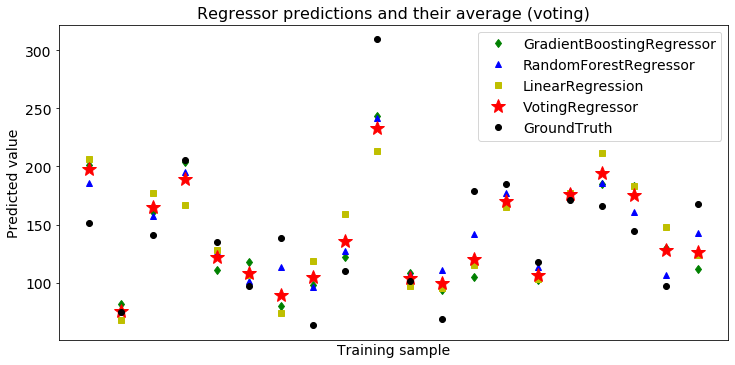

In [25]:
# Plot
plt.figure(figsize=(12, 5.8))
plt.plot(y_pred_gb, 'gd', label=gb_reg.__class__.__name__)
plt.plot(y_pred_rf, 'b^', label=rf_reg.__class__.__name__)
plt.plot(y_pred_lr, 'ys', label=lr_reg.__class__.__name__)
plt.plot(y_pred_voting, 'r*', ms=15, label=voting_reg.__class__.__name__)
plt.plot(y_new, 'ko', label='GroundTruth')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Predicted value')
plt.xlabel('Training sample')
plt.legend(loc='best', fontsize=14)
plt.title('Regressor predictions and their average (voting)', fontsize=16)

plt.show()

# 3. Bagging meta-estimator

**<font color='crimson'>获得 diverse 分类器的方法：</font>**

1. 使用不同的训练算法——前面已经介绍；

2. 使用同一个训练算法，但是在原始训练集的不同随机子集（different random subsets）上进行训练。

bagging 方法有多种，但主要区别是抽取训练集的随机子集：

- **[Bagging, 1996](https://scikit-learn.org/stable/modules/ensemble.html#b1996)——保留所有特征，抽取训练集样本的随机子集，并且样本是有放回的。** 即，在为每个 meta-estimator 从原始训练集中抽取子集来训练时，一个样本可以被多次抽取（采样）。同一样本可以在不同 meta-estimator 中被多次抽取。


- **[Pasting, 1999](https://scikit-learn.org/stable/modules/ensemble.html#b1999)——保留所有特征，抽取训练集样本的随机子集，样本是不放回的。** 即，在为每个 meta-estimator 从原始训练集中抽取子集来训练时，一个样本只能被抽取一次。同一样本可以在不同 meta-estimator 中被多次抽取。


样本维度上抽样使用： `max_samples` 和 `bootstrap`。

由于有放回抽样（Bootstrapping）在每个 base-estimator 的训练数据中引入了更多的多样性（a bit more diversity），所以，**bagging 的 bias 要比 pasting 稍微高一点**。然而，额外的多样性（extra diversity）意味着训练之后的 base-estimator 之间相关性更小（less correlated），所以集成之后的 **variance 降低**了。总的来说，**<font color='crimson'>bagging 通常会带来更佳的模型</font>**，这是它通常被首选的原因。但是，如果有富余的时间和 CPU 算力，应该使用交叉验证来同时评估 bagging 和 pasting，并选择最好的那一个。


- **[Random Subspaces, 1998](https://scikit-learn.org/stable/modules/ensemble.html#h1998)——保留全部样本，抽取训练集特征的随机子集。**
> `bootstrap=False` 并且 `max_samples=1.0` 并且 `bootstrap_features=True or/and max_features < 1.0`。


- **[Random Patches, 2012](https://scikit-learn.org/stable/modules/ensemble.html#lg2012)——在样本维度和特征维度同时进行抽样。**

样本维度上抽样使用： `max_features` 和 `bootstrap_features`。

**在特征维度上进行抽样在处理高维输入（如图像）时特别有用。**

**在特征维度上进行抽样会进一步增加 predictor 的多样性（diversity），以稍高一点的 bias 换取更低的 variance（trade a bit more bias for a lower variance）。**

一旦所有的 meta-estimator 都训练完成，可以聚合（少数服从多数用于分类，取平均值用于回归）所有 estimator 的预测结果来形成最终的预测。**<font color='crimson'>集成结果中的每个 estimator 的 bias 都高于该 estimator 在原始训练集训练后的 bias，但是通过聚合之后，同时降低了 bias 和 variance。</font>** 通常来说，**<font color='crimson'>最终结果（net result）是，与直接在原始训练集上训练单个 estimator 相比，集成之后的 bias 相近，但 variance 更低。</font>**

![bagging](./chap07_figs/bagging_and_pasting.png)

<br>

可以看出，**<font color='crimson'>estimators 可以通过不同的 CPU cores 或服务器（servers）并行（in parallel）训练，同样，在预测时也可以并行（in parallel）。这是 bagging 和 pasting 如此流行的原因之一——scale very well。</font>**

In [26]:
# 实现 bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=500, noise=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_train.shape, x_test.shape

((375, 2), (125, 2))

In [28]:
y[:10]

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])

In [29]:
# Bagging with decision trees
bagging_clf = BaggingClassifier(
    # 如果不指定，默认也是这个
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True, random_state=42)
bagging_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        random_state=42,
                                                        splitter='best'),
      

In [30]:
y_pred = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.904

In [31]:
# individual decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)

y_pred_tree = tree_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.856

In [32]:
def plot_decision_boundary_2(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

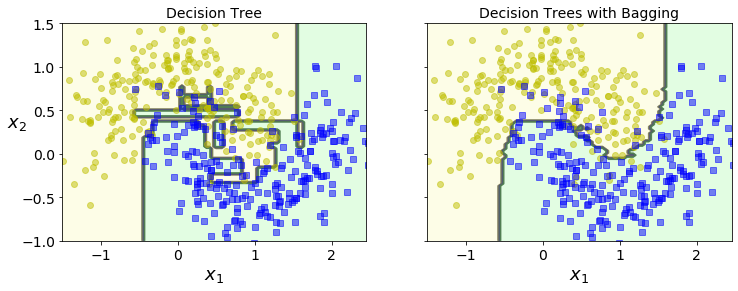

In [33]:
# Plot
fix, axes = plt.subplots(figsize=(12, 4), ncols=2, sharey=True)

plt.sca(axes[0])
plot_decision_boundary_2(tree_clf, x, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary_2(bagging_clf, x, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

**<font color='crimson'>如果 base estimator 可以估计每个 class 的概率（有 `predict_proba()` 方法），那么 `BaggingClassifier` 会自动执行 soft voting 而不是 hard softing。</font>**

## 3.1 对比性能

In [34]:
# Individual decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)

y_pred_tree = tree_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.856

In [35]:
# Bagging
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    random_state=42)
bagging_clf.fit(x_train, y_train)

y_pred_tree = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.904

In [36]:
# Pasting
pasting_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=False,
    random_state=42)
pasting_clf.fit(x_train, y_train)

y_pred_tree = pasting_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.92

In [37]:
# Random Subspace
random_subspaces_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=False,
    max_features=1,
    bootstrap_features=True,
    random_state=42)
random_subspaces_clf.fit(x_train, y_train)

y_pred_tree = random_subspaces_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.648

In [38]:
# Random Patches
random_patches_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=False,
    max_features=1,
    bootstrap_features=True,
    random_state=42)
random_patches_clf.fit(x_train, y_train)

y_pred_tree = random_patches_clf.predict(x_test)
accuracy_score(y_test, y_pred_tree)

0.856

## 3.2 Inspection

选择 Random Patches 来看看一些关于训练过程的事情：

In [39]:
# 拟合之后的 base estimator
len(random_patches_clf.estimators_)

500

In [40]:
# 用于训练每个 base estimator 的特征（length=n_estimators）
random_patches_clf.estimators_features_[:10]

[array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

In [41]:
# 用于训练每个 base estimator 的样本（length=n_estimators）
random_patches_clf.estimators_samples_[:5]

[array([218, 355,  19, 347, 276, 152, 238, 287, 281,  17, 282,  56, 304,
        151, 163, 128,  98, 266, 297, 328, 160, 348, 259, 212, 111, 181,
        118, 350,  21,  91, 180,  46, 313,  40, 220, 235, 209,  82, 134,
        197,  51, 357, 226, 147, 126, 101, 168, 316, 295,  55, 370, 139,
         61, 178, 136, 229, 274, 239,  33, 275, 356,  96, 237, 114,  50,
        246, 312, 153, 364, 367, 248, 195, 311, 272, 164,  47, 149,  31,
        323, 284, 333, 280, 202, 345, 315, 314, 156, 230, 145, 125, 278,
        310, 148,  80, 223, 331, 106,  35,  42, 225]),
 array([347,  42, 264,   2, 238, 311, 374, 215, 190, 211,  30, 100, 112,
         64,  94,  73, 164, 207,  76, 229, 235, 247, 156, 136, 328, 272,
        336, 353, 124, 123, 299, 352, 312,  98, 271, 148, 231, 145, 350,
        106, 261, 134,  88, 270,  32,  89, 273, 232, 338, 248, 122, 371,
        217, 241, 138,  79, 253, 167, 143, 254, 335, 286, 154,   8, 326,
        330, 208, 135,  22, 170, 305, 320, 329,  54, 284, 169,  44, 2

## 3.3 Out-of-Bag

在 bagging 中，对于任何给定的 base-estimator，有一些样本可能会被多次采样，而另一些样本可能不会被采样到。

`BaggingClassifier` 默认有放回地（`bootstrap=True`）抽取 m 个训练样本（`max_samples=m`），其中 m 表示原始训练集的大小。这意味着对于每个 base-estimator 平均大约只有 <font color='crimson'>63.2%</font> 的训练样本会被抽取到，剩下的 36.8% 的训练样本（不会被抽取到）称之为 **<font color='blue' size=2>out-of-bag (oob)</font>**。**对所有的 base-estimator 来说，这 <font color='crimson'>36.8%</font> 的样本并不相同。**

> 在总计 m 个样本中有放回抽样时，每个样本被抽到的概率是 $\frac{1}{m}$，不被抽到的概率是 $1-\frac{1}{m}$，这样抽取 m 次，不被抽到的概率是 $(1-\frac{1}{m})^m$，在 m 趋向于∞时，这个值等于 $e^{-1}$。

$$\lim\limits_{m\rightarrow\infty}(1-\frac{1}{m})^m=\lim\limits_{m\rightarrow\infty}(1+\frac{1}{-m})^{-m}=e^{-1}\approx0.3678794$$

可以使用 oob 样本来评估 bagging 集成方法，而不需要单独的验证集。**如果有足够多的 base-estimators，那么训练集中每个样本都有可能出现在多个 base-estimators 的 oob 样本中，所以对于该样本，这些 base-estimators 可以用来做出一个 fair ensemble prediction。**一旦对每个样本都有了一个预测，那么可以评估 ensemble 的预测结果了。

In [42]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True,  # Notice!
    random_state=42)
bagging_clf.fit(x_train, y_train)

# Score of the training dataset obtained using an out-of-bag estimate.
bagging_clf.oob_score_

0.896

对比在 oob 上的 acc 和在测试集上的 acc:

In [43]:
y_pred = bagging_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.92

**通过 `oob_decision_function_` 可以获得每个训练样本的 decision function。**

这里，由于 base-estimator 有 `predict_proba()` 方法，会输出每个样本的类别概率。

In [44]:
# 会对每个训练样本进行评估
len(x_train), bagging_clf.oob_decision_function_.shape

(375, (375, 2))

In [45]:
bagging_clf.oob_decision_function_[:10]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539]])

但是，如果 `n_estimators` 比较小，这可能会导致在抽样时部分样本被所有的 base-estimator 都采样到了，导致 oob 中没有该样本，那么此时 `oob_decision_function_` 会包含 NaN。

## 3.4 Generation error = Bias+Variance+Noise

> 1. https://zhuanlan.zhihu.com/p/38853908
> 2. https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

如果能够获得所有的数据，并在这个数据集上进行训练，将损失最小化，那么学到的模型就可以称之为“真实模型”。但是，获取所有数据并不现实，所以这个“真实模型”无法获得。所以，最终的目的就是学习一个模型使其更加接近这个“真实模型”。

但是单纯地将训练数据的损失最小化并不能保证在应用时仍然是最优，甚至是不能在实际中使用。所以需要使得训练模型的泛化误差最小。

模型的**泛化误差（generation error）**可以分解为**偏差（bias）**、**方差（variance）**、和**噪声（noise）**。

> 记 $y_D$ 为数据集中标签，$y$ 为真实标签，$f$ 为训练得到的（多个）模型，$f(x)$ 为（多个）模型的预测值，模型预测值的期望 $\overline y=E[f(x)]$。

- **<font color='blue'>偏差（Bias）</font>**——原因在于错误的假设，比如假设数据是线性的，而实际上是二次的。高偏差模型最有可能欠拟合训练数据。<font color='crimson'>是用所有能获得的数据集（多个数据集）进行训练，这些训练所得模型（对应多个模型）的输出平均值与“真实模型”的输出值之间的差异就是 bias。</font>

> $Bias=(\overline y-y)^2$


- **<font color='blue'>方差（Variance）</font>**——由于模型对训练数据的细微变化过于敏感（方差越大越敏感）。高自由度的模型（如高阶多项式模型）可能具有较高的方差。<font color='crimson'>不同训练数据集训练出的模型输出值之间的差异就是 variance。</font>

> $Variance=E[(f(x)-\overline y)^2]$


**增加模型的复杂度通常会降低模型的 bias 但会增加模型的 variance；反过来，降低模型的复杂度会增加模型的 bias 但会降低 variance。这是 <font color='crimson'>bias-variance trade-off。</font>**


- **<font color='blue'>噪声（Noise）</font>**——数据本身的噪声导致，是不可避免的误差，（数据质量）决定了学习的上限。在训练数据给定的情况下，上限是确定的，要做的（训练模型）就是尽可能接近这个上限。减少这部分误差的唯一方法就是清理数据。

> $Noise=E[(y_D-y)^2]$

在实际中，能够用来训练模型的数据只是全部数据的一个子集。假设，对于回归任务，现在收集到几组（50）不同的训练数据，由于每组数据不同，训练模型的最小损失值也不同，他们与“真实模型”的最小损失也是不同的。

In [46]:
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50   # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1    # Standard deviation of the noise

np.random.seed(0)

In [47]:
# 生成数据
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)
    
    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0, noise, n_samples)
    
    X = X.reshape((n_samples, 1))
    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

In [48]:
# 生成了 50 个训练数据集——X: (n_samples, 1), y: (n_samples,)
len(X_train), X_train[0].shape, len(y_train), y_train[0].shape

(50, (50, 1), 50, (50,))

In [49]:
# 对于同一个测试集 X 有 50 个 y
X_test.shape, y_test.shape

((1000, 1), (1000, 50))

In [50]:
y_test  # 测试集的标签(1000, 50)

array([[ 0.10738585,  0.04997564, -0.01657265, ..., -0.00521997,
         0.08652174,  0.12890911],
       [ 0.2438684 ,  0.02243302, -0.06748378, ..., -0.08716873,
        -0.08342711, -0.21213919],
       [-0.13962154,  0.12361823, -0.06607167, ...,  0.01681198,
         0.03025682,  0.07964042],
       ...,
       [ 0.02207769, -0.06953669,  0.1406166 , ...,  0.17353134,
         0.10173286, -0.02550795],
       [-0.10031599,  0.01676112,  0.10120243, ...,  0.13319717,
         0.05913374, -0.18129752],
       [ 0.06787607, -0.03343733, -0.04662948, ..., -0.06927669,
         0.07708652,  0.04616621]])

In [52]:
# 可以更改可以探索其他 estimator 的 bias-variance 分解
# 对具有高方差（high variance）的 estimator 很有效
# 对具有低方差（low variance）的 estimator 效果较差
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

estimators = [
    ('Tree', DecisionTreeRegressor()),
    ('Bagging(Tree)', BaggingRegressor(DecisionTreeRegressor()))
]

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


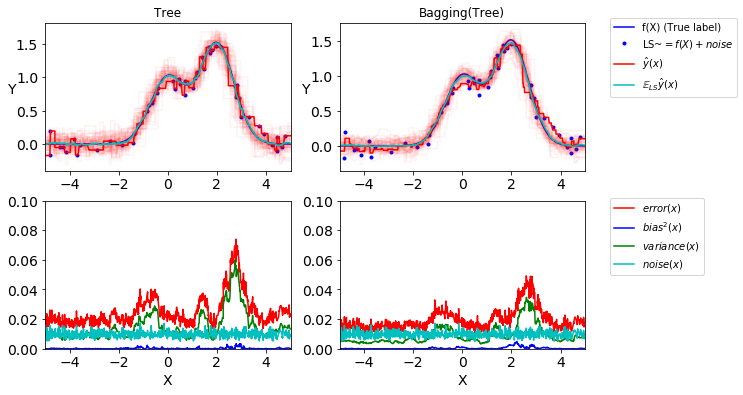

In [53]:
plt.figure(figsize=(12, 6))

for idx, (name, estimator) in enumerate(estimators):
    y_preds = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        # 在 50 个数据集上分别训练一个模型
        estimator.fit(X_train[i], y_train[i])
        # 并记录每个测试样本对应的（50个）预测值
        y_preds[:, i] = estimator.predict(X_test)  # (1000, 50)

    # Bias^2 + Variance + Bias = Generiation error
    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_preds, axis=1)) ** 2
    y_var = np.var(y_preds, axis=1)

    # 测试样本的期望误差
    y_error = np.zeros(n_test)
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_preds[:, i]) ** 2
    y_error /= (n_repeat * n_repeat)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, len(estimators), idx+1)
    # 真实标签
    plt.plot(X_test, f(X_test), 'b', label='f(X) (True label)')
    # 第一个训练数据
    plt.plot(X_train[0], y_train[0], '.b', label='LS~$=f(X)+noise$')

    # 每个测试样本的预测值
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_preds[:, i], 'r', label='$\^y(x)$')
        else:
            plt.plot(X_test, y_preds[:, i], 'r', alpha=0.05)

    # 预测值的期望
    plt.plot(X_test, np.mean(y_preds, axis=1), 'c',
             label=r"$\mathbb{E}_{LS} \^y(x)$")
    plt.xlim([-5, 5])
    plt.ylabel('Y', rotation=0)
    if idx == len(estimators) - 1:
        plt.legend(loc=(1.1, .5))
    plt.title(name)

    plt.subplot(2, len(estimators), len(estimators) + idx + 1)
    plt.plot(X_test, y_error, 'r', label='$error(x)$')
    plt.plot(X_test, y_bias, 'b', label='$bias^2(x)$')
    plt.plot(X_test, y_var, 'g', label='$variance(x)$')
    plt.plot(X_test, y_noise, 'c', label='$noise(x)$')
    plt.xlim([-5, 5])
    plt.xlabel('X')
    plt.ylim([0, 0.1])
    if idx == len(estimators) - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

在左上图中，红线+淡红线（共 50 条线）表示每个测试样本的预测值（对应 50 个不同模型），方差就是这个红色光束的宽度。偏差对于所有（50个）estimator 预测值的期望（青色）与“真实模型”预测值（蓝线）之间的差异。可以看到 bias 非常小，但 variance 比较高。

在左下图中，在每一个测试样本上，都将期望误差（红色）进行了拆解。证实了，bias 较小（蓝色），variacne 较大（绿色），噪声几乎不变，在 0.1 附近。

在右图中，用 `BaggingRegressor(DecisionTreeRegression)` 代替 `DecisionTreeRegression`。可以看到 bias 比较大。右上图，预测值的期望（青线）与“真实模型”预测值（蓝线）的差异较大，在右下图中，bias 的曲线也稍微高一点。对于 variance，红色线光束（预测值）较窄，表明 variance 更低，如有下图中的 variance 曲线（绿色）更低。

总之，bias-variance 的分解不再相同。这种 trade-off 对于 bagging 来说更有利，会稍微增加 bias 但会更多地降低 variance，因此期望误差更小（底层图中的红色曲线），期望误差的降低主要是因为 variacne 更低。

# 4. Forests of randomized trees

[`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) 包含 2 个基于随机决策树（randomized decision trees）的平均算法（averaging algorithm）：

1. RandomFroest

2. Extra-Trees

这 2 种算法都是<font color='crimson'>专为 trees 设计</font>的 <font color='crimson'>perturb-and-combine</font> 技术。这意味着在 estimator 构建的过程中通过引入<font color='crimson'>随机性（randomness）</font>来创建一组多样的（diverse）base-estimators。**ensemble 之后的输出是 base-estimator 输出的平均值。**

## 4.1 Random Forests

Random Forests 是决策树的集成，通常用 bagging（有时是 pasting）方法训练，训练集的大小通过 `max_samples` 来设置。

有 2 种实现方法：

1. `BaggingClassifier(DecisionTreeClassifier)` / `BaggingRegressor(DecisionTreeRegressor)`

2. `RandomForestClassifier` / `RandomForestRegressor`

方法二更方便，对决策树更优化。但想使用决策树之外的 base-estimator 可以使用方法一。

**<font color='crimson'>Random Forests 中的随机性（randomness）：</font>**

- 每个决策树是在有放回抽样（`bootstrap=True`）得到的数据集上训练的；


- 进一步，在构造决策树的过程中，在分裂所有特征上要么在特征的随机子集（`max_features`）上寻找最佳分裂点。

**<font color='crimson'>这 2 种随机性的目的是降低 estimator 的 variance。</font>**

事实上（indeed），单个决策树通常表现出 high variance 并容易过拟合。引入随机性后产生的多个决策树在一定程度上可以使得预测误差解耦（somewhat decouple prediction errors）。通过对预测值取平均，一些误差可以被消除（cancel out）。Random Forests 通过组合多种树（combine diverse trees）来降低 variance，有时是以 bias 稍微增加为代价的。在实践中，variance 的减少是显著的，因此产生一个更好的模型。

In [54]:
x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

x_train.shape, y_train.shape

((375, 2), (375,))

In [55]:
# 方法一
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bagging_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        random_state=None,
                                                        splitter='best'),
    

In [56]:
from sklearn.ensemble import RandomForestClassifier

# 方法二
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
y_preds_bagging = bagging_clf.predict(x_test)
y_preds_rf = rnd_clf.predict(x_test)

sum(y_preds_bagging == y_preds_rf) / len(y_preds_rf)

1.0

除少数参数外，`RandomForestClassifier` 拥有 `DecisionTreeClassifier` 的所有参数（控制树的生长方式），以及 `BaggingClassifier` 的所有参数（控制集成）。

在 Scikit-Learn 中，`RandomForestClassifier` 通过对概率取平均来结合所有的分类器，而不是进行投票。

## 4.2 Extremely Randomized Trees

在 Random Forests 中，在分裂结点时使用的是特征的随机子集最为候选，然后寻找最佳的切分点（特征的最佳阈值）。

但，**<font color='crimson'>再进一步，如果对每个特征使用随机阈值，而不是搜索得到的最佳阈值，则有可能会让决策树的生成更加随机。</font>** 这种极端随机（extremely random）的决策树组成的 forest 称之为 **<font color='blue'>Extremely Randomized Trees (Extra-Trees for short)</font>**。Extra-Trees 的训练通常比 Random Forests 更快，这是因为在分裂结点时寻找最佳阈值是生成决策树中最耗时的任务之一。

**这同样是以更高点的 bias 换取更低点的 variance。**

<div class="alert alert-block alert-info">
    很难预先知道 <code>RandomForestClassifier</code> 是否比 <code>ExtraTreesClassifier</code> 更好或更差。通常来说，唯一的方式是 2 种都试一下，使用较差验证来比较。
</div>

In [58]:
from sklearn.datasets import make_blobs
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score


x_exp, y_exp = make_blobs(
    n_samples=10000, n_features=10, centers=100, random_state=0)
dt_clf = DecisionTreeClassifier(
    max_depth=None, min_samples_split=2, random_state=0)
rf_clf = RandomForestClassifier(
    n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
et_clf = ExtraTreesClassifier(
    n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

dt_scores = cross_val_score(dt_clf, x_exp, y_exp, cv=5)
rf_scores = cross_val_score(rf_clf, x_exp, y_exp, cv=5)
et_scores = cross_val_score(et_clf, x_exp, y_exp, cv=5)

dt_scores.mean(), rf_scores.mean(), et_scores.mean()

(0.9823000000000001, 0.9997, 1.0)

## 4.3 参数（Parameters）

使用这些方法需要调参的参数主要是 **`n_estimators`** 和 **`max_features`**。

- **`n_estimators`** —— forest 中的 tree 的数量。越大，计算时间越长。而且，在 tree 超过一定的数量之后，性能将停止显著增加。


- **`max_features`** —— 在分裂结点时需要考虑的特征数量（原始特征的随机子集）。值越小，variance 降低得越多，但是 bias 的增加也越高。经验上的默认值，对于回归问题，使用 `max_features=None`（总是考虑所有的特征）；对于分类问题，使用 `max_features='sqrt'`（随机子集的大小是 `sqrt(n_features)`）。


- 设置 `max_depth=None` 并且 `min_samples_split=2`（即，tree 完全生长开）通常能获得好结果。


- 在 Random Forests 中，默认使用有有放回的抽样（`bootstrap=True`），而且 extra-trees 中，默认使用全部数据（`bootstrap=False`）。使用有放回抽样，通常可以通过 oob 样本来评估泛化性能（`oob_score=True`）。


- 默认的设置，通常不是最优的，而且可能导致模型消耗大量的 RAM。**最佳参数得通过交叉验证获得。**

## 4.4 并行性（Parallelization）

通过使用 `n_jobs` 树的构造过程（construction），以及预测计算过程可以并行进行。

`n_jobs=k` 表示将计算分成 k 个 job，并且 k 个 core 上进行。`n_jobs=-1` 表示使用所有的 cores。**由于进程间的通信开销（inter-process communication overhead），加速可能不是线性的，即使用 k 个 jobs 的速度增加并不是 k 倍。**

在构建大量的树，或者构造单个树需要大量时间时（大数据集），加速还是蛮明显的。

## 4.5 （MDI）特征重要性（Feature importance）

特征作为树中一个决策结点（decision node）的相对排名（即深度），可用于评估该特征对目标变量的 predictability 的相对重要性。

在树顶部使用的特征对大比例输入样本（即，大部分样本）的最终预测决策贡献较大。因此，这个样本比例数的期望值可以用作特征相对重要性的估计。在 Scikit-Learn 中，特征作用于的样本比例数（或，受益于该特征的样本比例数），与分裂该特征带来的纯度（impurity）下降相结合，来建立该特征预测能力（predictive power）的标准化估计（normalized estimate）。

通过对多个随机树的预测能力估计（the estimate of predictive ability）取平均，可以减少这种估计的方差，并且可用于特征选择（feature selection）。这称为 **<font color='blue'>Mean Decrease in Impurity</font>** 或 **<font color='blue'>MDI</font>**——更多关于 MDI 和 feature importance 的信息参考[paper, 2014](https://scikit-learn.org/stable/modules/ensemble.html#l2014)。

简单来说，通过查看使用特征作为树结点之后的 impurity 平均减少量来衡量该特征的相对重要性——是一个加权平均值，每个结点的权重等于其关联的样本数量。

假设，G 表示结点的 impurity，在树 T 中，对于结点 a (也表示样本数量)，使用特征 i 分裂后，左子结点是 b (也表示样本数量)，右子结点是 c (也表示样本数量)，那么该特征 X 相对重要性为（m 为根结点中的样本数量，等于用于训练树的样本数量）

$$FI_{ai}=\frac{a}{m}*({G_a} - \frac{b}{a}*{G_b} - \frac{c}{a}*{G_c})$$

如果树 $T$ 中有 $K$ 个节点都使用了特征 i，那么特征 i 的重要性是：

$$FI_i = \sum^{K}_{k=1}{FI_{ki}}$$

然后，将树 $T$ 中所有特征（n个）的相对重要性进行归一化：

$$FI_j = \frac{FI_j}{\sum_{j=1}^{n}{FI_j}}$$

在 Random Forest 中，需要对特征在每棵树中的相对重要性取平均值作为该特征最终的相对重要性（各特征重要性之和等于1）。

In [59]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
x, y = iris.data, iris.target
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(x, y)


# 代码计算
# 特征的重要性
feature_importances = dt_clf.tree_.compute_feature_importances(normalize=False)
# 归一化后的特征重要性
# feature_importances_nomalized = dt_clf.tree_.compute_feature_importances(normalize=True)
feature_importances_nomalized = feature_importances / np.sum(feature_importances)
feature_names = iris.feature_names

print("Name, feature_importance, nomalized_feature_importance:")
print("-"*60)
for items in zip(feature_names, feature_importances, feature_importances_nomalized):
    print("{}, {}, {}".format(*items))

Name, feature_importance, nomalized_feature_importance:
------------------------------------------------------------
sepal length (cm), 0.008888888888888889, 0.013333333333333329
sepal width (cm), 0.0, 0.0
petal length (cm), 0.37603730542136354, 0.5640559581320451
petal width (cm), 0.2817404723564144, 0.4226107085346215


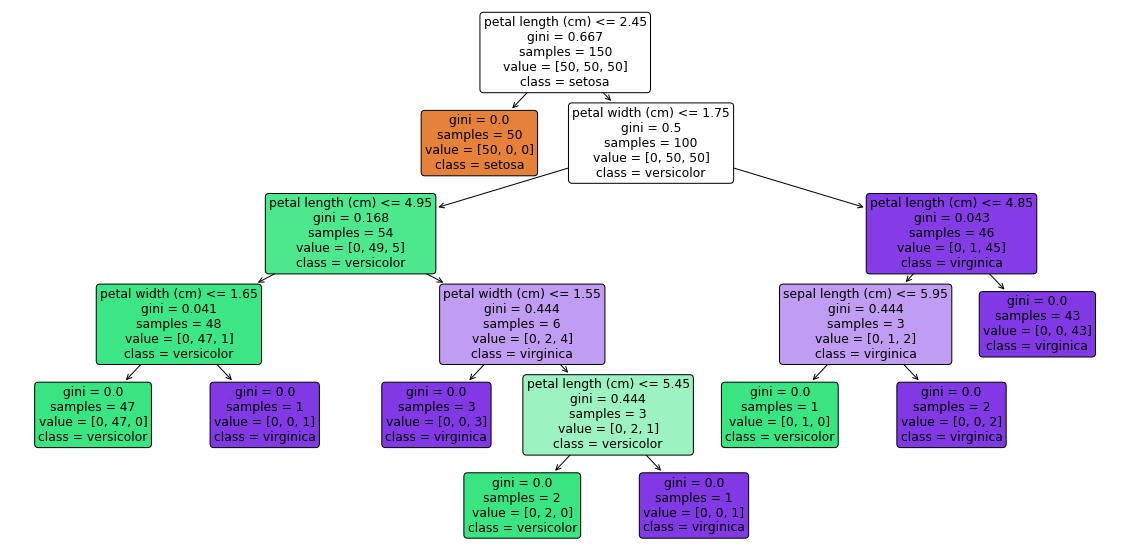

In [60]:
# Plot decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True)
plt.show()

对着上图，手动计算每个特征的重要性：（应该有更 elegant 的代码，从树的 attribute 下手）

In [61]:
# sepal length 特征重要性
sl = 3/150 * (0.444 - 1/3*0 - 2/3*0)
sl

0.00888

In [62]:
# petal length 特征重要性
pl = (
    (150/150 * (0.667 - 50/150*0 - 100/150*0.5))
    + (54/150 * (0.168 - 48/54*0.041 - 6/54*0.444))
    + (3/150 * (0.444 - 2/3*0 - 1/3*0))
    + (46/150 * (0.043 - 3/46*0.444 - 43/46*0)))
pl

0.3764533333333334

In [63]:
# petal width 特征重要性
pw = (
    (100/150 * (0.5 - 54/100*0.168 - 46/100*0.043))
    + (48/150 * (0.041 - 47/48*0 - 1/48*0))
    + (6/150 * (0.444 - 3/6*0 - 3/6*0.444)))
pw

0.2816666666666666

In [64]:
# 归一化后特征重要性
sl / (sl + pl + pw), pl / (sl + pl + pw), pw / (sl + pl + pw)

(0.013313343328335833, 0.5643978010994504, 0.4222888555722138)

训练一个随机森林：

In [65]:
# 随机森林的特征重要性
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf.fit(x, y)

rf_feature_importance = rf_clf.feature_importances_
rf_feature_importance

array([0.1292683 , 0.01582194, 0.4447404 , 0.41016935])

值越大，特征对预测的贡献度越高。

In [66]:
# 随机森林中每个 base-estimator 的特征重要性
fi_per_estimator = np.array([
    base_estimator.tree_.compute_feature_importances(normalize=True)
    for base_estimator in rf_clf.estimators_])
fi_per_estimator

array([[0.        , 0.0283598 , 0.06538049, 0.90625971],
       [0.        , 0.        , 0.5240574 , 0.4759426 ],
       [0.03355254, 0.05492528, 0.5527283 , 0.35879388],
       [0.1620418 , 0.        , 0.82841837, 0.00953983],
       [0.04743633, 0.01159555, 0.46320532, 0.4777628 ],
       [0.03575322, 0.01335648, 0.41691885, 0.53397144],
       [0.3484898 , 0.        , 0.50518553, 0.14632467],
       [0.3491996 , 0.0133547 , 0.42473755, 0.21270815],
       [0.30653337, 0.0071725 , 0.59421983, 0.0920743 ],
       [0.00967636, 0.02945508, 0.07255241, 0.88831615]])

In [67]:
fi_per_estimator.mean(axis=0)

array([0.1292683 , 0.01582194, 0.4447404 , 0.41016935])

In [68]:
fi_per_estimator.mean(axis=0) == rf_feature_importance

array([ True,  True,  True,  True])

In [183]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)


categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])


rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(memory=None,
          

**<font color='crimson'>在检查（inspect）特征重要性之前，检查模型的预测性能是否足够很重要。</font>** 毕竟，没有任何预测能力的模型的特征重要性没什么用。

In [184]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


过拟合了。可以设置 `min_samples_leaf=5` 或者 `min_samples_leaf=10` 来做一些限制。

但这里，继续使用这个过拟合模型，来说明基于 MDI 的特征重要性的缺点——偏向于值较多的特征，尤其是连续型特征。

结果，没有任何预测能力的 `random_num` 的最重要。

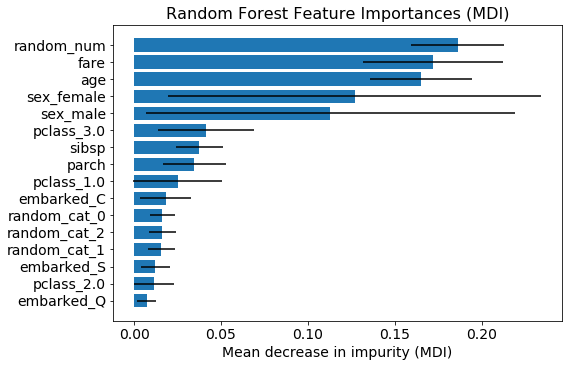

In [185]:
# MDI
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
std = np.std([
    tree.feature_importances_ for tree in rf.named_steps['classifier'].estimators_],
    axis=0)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(8, 5.2))
# 蓝色柱子表示特征重要性，误差条（error bars）表示树之间的特征重要性的波动（方差）
ax.barh(y_ticks, tree_feature_importances[sorted_idx], xerr=std[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel("Mean decrease in impurity (MDI)")
ax.set_title("Random Forest Feature Importances (MDI)", fontsize=16)
fig.tight_layout()
plt.show()

**<font color='crimson'>基于树模型，并用 MDI (Mean Decrease in Impurity) 计算的特征重要性有 2 个缺点</font>——可能会产生误导性结论（misleading conclusions）：**

- 根据从**训练集**上得到的统计数据计算出，因此不一定会给出哪些特征对在验证集/测试集上的预测结果影响最重要。即，当模型过拟合时，对于那些在未知数据上表现较差的特征，可能会获得更多的重要性。


- 是严重有偏的（strongly biased），会偏向于值较多的 cardinality 特征（尤其是连续型特征），而不是 low cardinality 特征（如二元特征，或种类较少的离散型特征）。


- 只适用于 tree-based 模型。

## 4.6 [排列特征重要性（Permutation feature importance）](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance)

**排列特征重要性可以解决上面（基于 MDI 特征重要性）的问题。**

排列特征重要性是一种 inspection technique，**<font color='crimson'>在数据是表格型的（tabular）时候，适用于任何 fitted estimator</font>**——尤其是非线性（non-linear）或黑盒模型（opaque estimator）。

排列特征重要性定义为，当单个特征随机打乱（randomly shuffled）的时候，模型得分的下降程度。这个步骤（单个特征的值随机打乱）打破了特征与标签之间的关系，因此，模型分数的下降表示模型对特征的依赖程度。

这种技术是<font color='crimson'>模型无关的（model agnostic）</font>，并且可以使用特征值的不同排列顺序进行多次计算。

**排列特征重要性既可以在训练集上计算，也可以在验证集/测试集上计算。使用验证集时，可以突出哪些特征对模型的泛化误差贡献最大。在训练集上重要，但在验证集上不重要的特征可能会导致模型过拟合。**

<div class="alert alert-block alert-info">
    <b>被 bad 模型（cv 的分数低）认为不重要的特征，对于 good 模型可能非常重要。因此，在计算特征重要性之前，使用验证集（或者交叉验证）来评估模型的预测能力非常重要。</b><br><br>
    <b>排列特征重要性并不反应特征的内在预测能力（intrinsic predictive value），而是反应出该特征对特定模型的重要性。</b>
</div>

假设，$m$ 表示训练好的模型，$D$ 表示 tabular （训练或验证）数据集，$s$ 表示模型在 $D$ 分数（如，分类任务的 accuracy，回归任务的 $R^2$。

对于每一个特征 $j$（$D$ 中的列）：

- 重复 $k$ $(1,..., K)$ 次：
  - 随机打乱特征 $j$ 的值，生成一个数据集 $D$ 的损坏版本（corrupted version），称之为 $D_{k,j}$
  - 计算模型在 $D_{k,j}$ 的分数 $s_{k,j}$


- 计算特征 $j$ 的重要性（$FI_j$）：

$$FI_j = s - \frac{1}{K}\sum^{K}_{k=1}s_{k,j}$$

```python
X_permuted = X.copy()  # X: pd.DataFrame
shuffling_idx = np.arange(X.shape[0])
for n_round in range(n_repeats):
    random_state.shuffle(shuffling_idx)
    col = X_permuted.iloc[shuffling_idx, col_idx]
    col.index = X_permuted.index
    # 其余特征值的顺序不动
    X_permuted.iloc[:, col_idx] = col
```

In [186]:
X_raw = pd.DataFrame(
    np.arange(12).reshape(4, 3),
    columns=['Feat_1', 'Feat_2', 'Feat_3'])
X_raw

,Feat_1,Feat_2,Feat_3
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11


In [187]:
X_permuted = X_raw.copy()  # X: pd.DataFrame
shuffling_idx = np.arange(X_raw.shape[0])
# n_repeats=1
np.random.shuffle(shuffling_idx)  # in-place
# 第一个特征 —— Feat_1
col = X_permuted.iloc[shuffling_idx, 0]
col.index = X_permuted.index
X_permuted.iloc[:, 0] = col

X_permuted

,Feat_1,Feat_2,Feat_3
0,0,1,2
1,6,4,5
2,3,7,8
3,9,10,11


与 4.5 对比：

In [188]:
# Permutation Feature Importance
from sklearn.inspection import permutation_importance

# 比较慢
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=4)

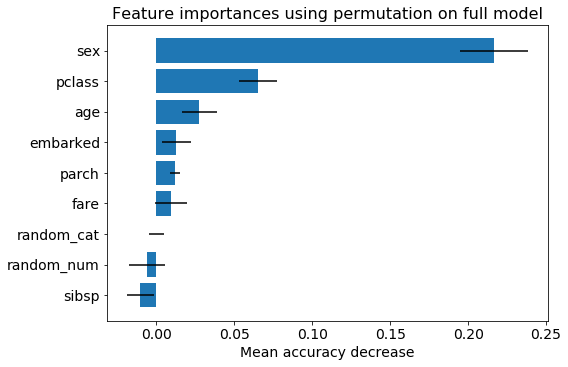

In [190]:
permutation_feature_importances = result.importances_mean  # 和不等于1
sorted_idx_p = permutation_feature_importances.argsort()
feature_names = X_test.columns

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(8, 5.2))
# 蓝色柱子表示特征重要性，误差条（error bars）表示树之间的特征重要性的波动（方差）
ax.barh(y_ticks, permutation_feature_importances[sorted_idx_p],
        xerr=result.importances_std[sorted_idx_p])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx_p])
ax.set_xlabel("Mean accuracy decrease")
ax.set_title("Feature importances using permutation on full model", fontsize=16)

fig.tight_layout()
plt.show()

两个随机特征（`random_num` 和 `random_cat`）的重要性都很低（接近于 0）。

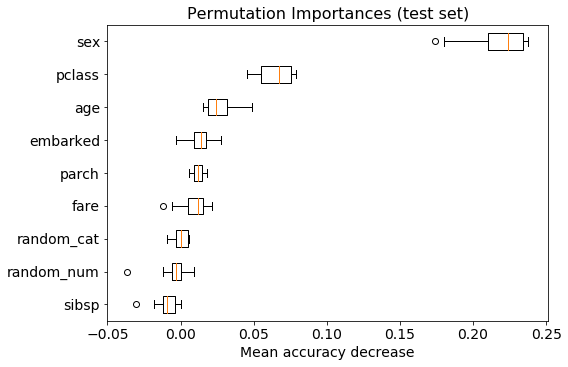

In [191]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 5.2))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_xlabel("Mean accuracy decrease")
ax.set_title("Permutation Importances (test set)", fontsize=16)
fig.tight_layout()
plt.show()

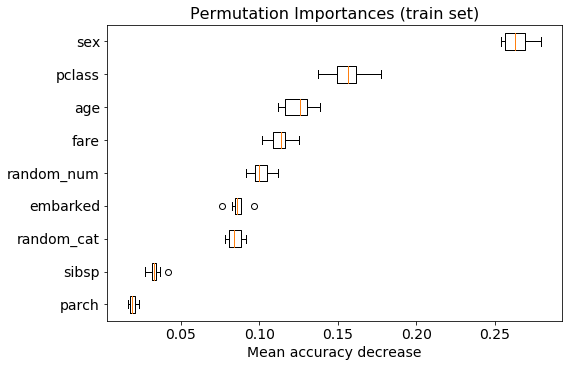

In [192]:
# 也可以在训练集上计算排列特征重要性
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 5.2))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_xlabel("Mean accuracy decrease")
ax.set_title("Permutation Importances (train set)", fontsize=16)
fig.tight_layout()
plt.show()

可以看出，`random_num` 的重要性排名比在测试集上要高。这个差异证实了，RF 模型使用这个特征时过拟合了。可以限制 `min_samples_leaf=10`。

**<font color='crimson'>Permutation feature importance 的缺点：</font>**当 2 个特征具有相关性（特征 a 和特征 b），并使用其中 1 个特征（特征 a）进行 permutation 时，模型仍可以通过相关特征（特征 b）来 acces 该特征的信息。这可能会导致者 2 个特征的重要性降低，而实际上可能很重要。

<font color='crimson'>解决这一问题的一种方法是，将具有高相关性的特征进行聚类，并且在每一个 cluster 中只留一个特征。</font>

In [196]:
from collections import defaultdict

from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from sklearn.datasets import load_breast_cancer

In [197]:
# 数据集中含有 multicollinear 特征
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


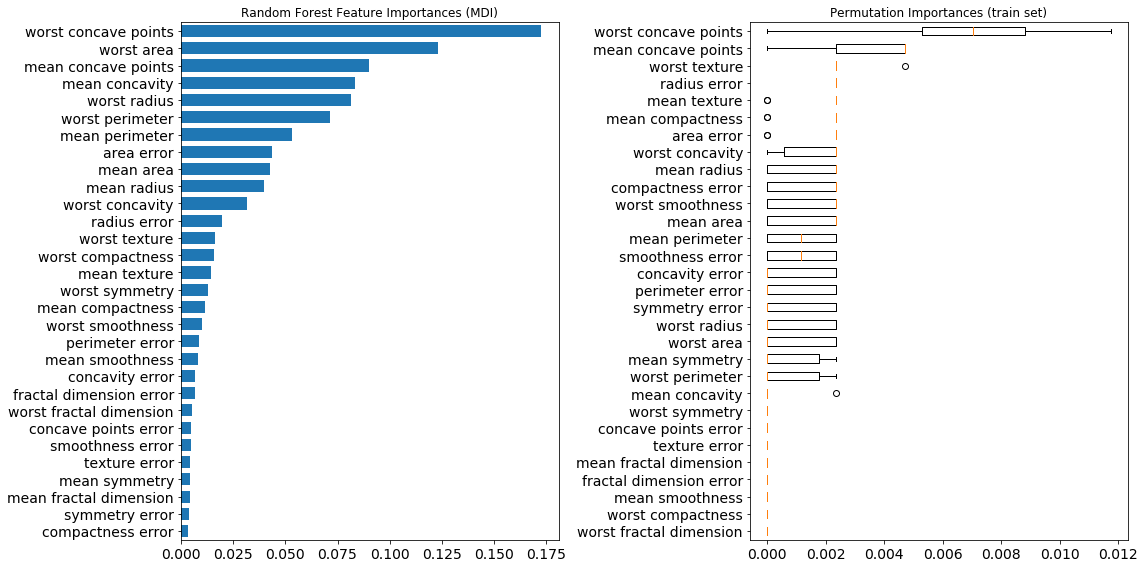

In [201]:
# Plot the tree based feature importance and the permutation importance
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.set_title("Random Forest Feature Importances (MDI)", fontsize=12)

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
ax2.set_title("Permutation Importances (train set)", fontsize=12)
fig.tight_layout()
plt.show()

从右图中，可以看出，在 permute 一个特征时，模型的性能最多下降 0.012，这表明所有的特征都是不重要的。

但，这与模型在测试集上高性能相悖——一些特征肯定是重要的。

在训练集上计算的特征排列重要性，显示的是在训练期间模型对每个特征的依赖程度。

<font color='crimson'>当特征具有共线性（collinear）时，permute 一个特征对模型性能只有非常少的影响，因为可以从相关的特征中获取到相同的信息。一种处理共线性特征的方法是，在 Spearman rank-order correlations 上使用层次聚类（hierarchical clustering），然后选择一个阈值，并从每个 cluster 中选择一个特征。</font>

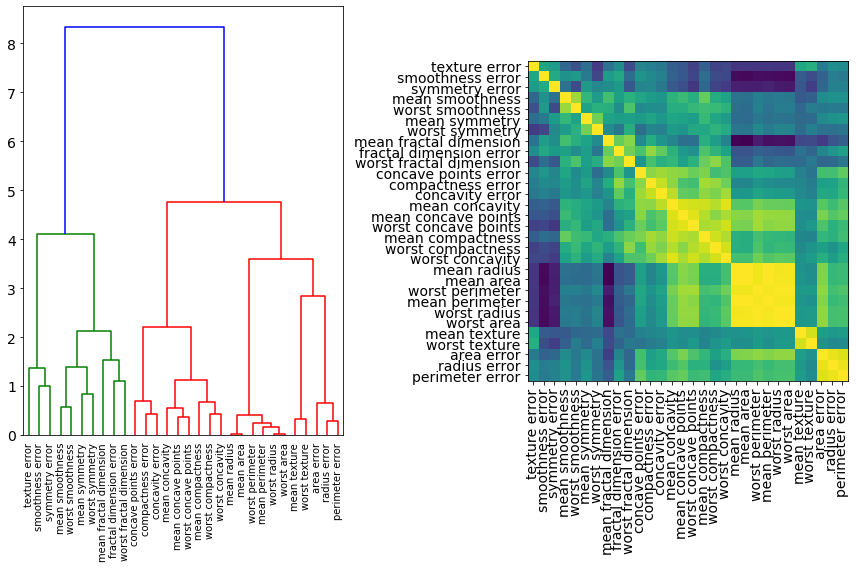

In [214]:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [216]:
# 手动选择一个阈值来生成 cluster，并从每个 cluster 中选择一个特征
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [217]:
# 基于选择的特征重新训练一个模型，acc 并没有太大变化
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97


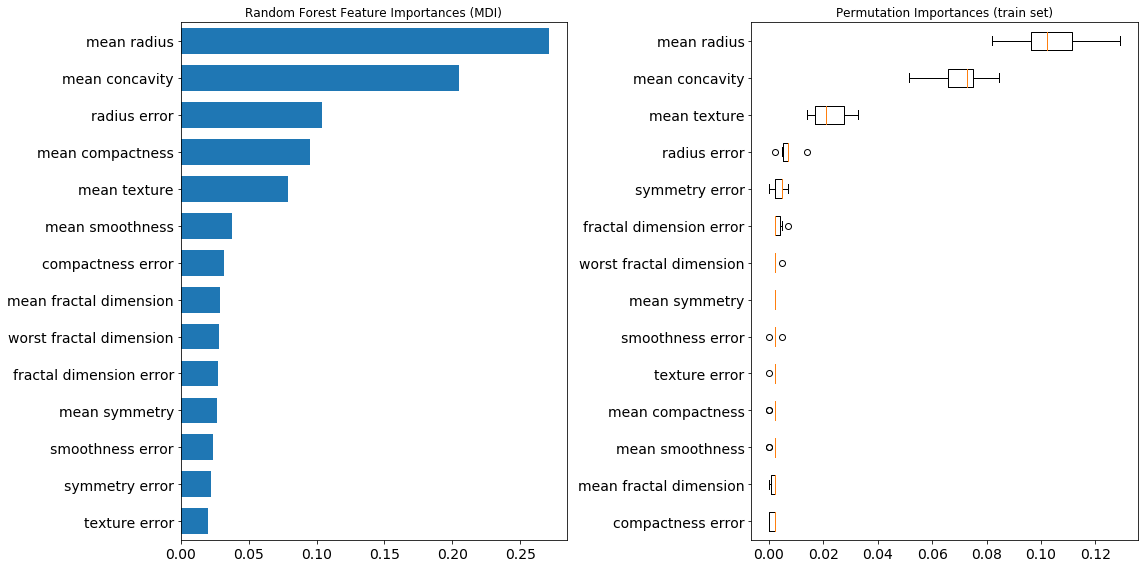

In [221]:
# Plot the tree based feature importance and the permutation importance
result = permutation_importance(clf_sel, X_train_sel, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[selected_features][tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax1.set_title("Random Forest Feature Importances (MDI)", fontsize=12)

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[selected_features][perm_sorted_idx])
ax2.set_title("Permutation Importances (train set)", fontsize=12)
fig.tight_layout()
plt.show()

## 4.7 Totally Random Trees Embedding

一种将数据转换成高维稀疏表示（ high-dimensional sparse representation）（可能有助于分类）的无监督的数据转换（transformation）方法。

> **在高维空间中，线性分类器通常表现更佳。对于稀疏的 binary 数据，BernoulliNB 特别适合。**

使用一组完全随机树（completely random），用叶子节点的索引（index）（从 1 开始）来将落到该叶子结点中的样本进行编码（encode）。然后用 one-of-K manner 方法将 index 编码成高维、稀疏的二进制。

**这种编码可以非常高效地计算出来，并且可作为其他算法的基础（basis）。**

编码之后的大小（size）及稀疏性（sparsity）受树的数量及树的最大深度影响。编码之后的大小：`n_out <= n_estimators * max_leaf_nodes`。如果 `max_leaf_nodes=None`，那么叶子结点最多 `n_estimators * 2 ** max_depth`。

相邻数据（neighboring samples）更有可能位于树的同一个叶子结点中，因此，这种转换（transformation）是一种隐式的（implicit）、非参数（non-parametric）的密度估计（density estimation）。

In [222]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10)
# 用于训练集成模型，用于训练线性模型
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = \
    train_test_split(X_full_train, y_full_train, test_size=0.5,
                     random_state=10)

In [223]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

random_forest = RandomForestClassifier(
    n_estimators=10, max_depth=3, random_state=10)
random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=10, max_depth=3, random_state=10)
_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

In [227]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# 不需要单独训练
random_tree_embedding = RandomTreesEmbedding(
    n_estimators=10, max_depth=3, random_state=0)
# 直接与 LR 组成 pipeline
rt_model = make_pipeline(
    random_tree_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(memory=None,
         steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=10, n_jobs=None,
                                      random_state=0, sparse_output=True,
                                      verbose=0, warm_start=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', rand

In [240]:
# 每个样本落在每棵树中的叶子结点索引（从 1 开始）, shape=(20000, 10)
rt_model.named_steps['randomtreesembedding'].apply(X_train_linear)

array([[ 3, 11, 14, ..., 10,  7,  6],
       [13, 13, 14, ..., 13,  7, 10],
       [13,  7, 14, ..., 10,  7, 14],
       ...,
       [13, 11, 14, ..., 10,  7, 13],
       [10,  7,  3, ..., 10,  7, 14],
       [ 3, 13,  6, ...,  4,  7,  6]])

In [246]:
rt_model.named_steps['randomtreesembedding'].transform(X_train_linear)

<20000x75 sparse matrix of type '<class 'numpy.float64'>'
	with 200000 stored elements in Compressed Sparse Row format>

In [247]:
rt_model.named_steps['randomtreesembedding'].transform(X_train_linear).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [245]:
# 将 rf 和 gbdt 与 lr 组成 pipeline
# 由于 rf 和 gbdt 中的转换是 apply 方法，而 pipeline 中期望的 transform 方法
# 因此，使用 FunctionTransformer 来封装 apply
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


def rf_apply(X, model):
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(
    rf_apply, kw_args={"model": random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder, OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000))
_ = rf_model.fit(X_train_linear, y_train_linear)



def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting})

gbdt_model = make_pipeline(
    gbdt_leaves_yielder, OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000))
_ = gbdt_model.fit(X_train_linear, y_train_linear)

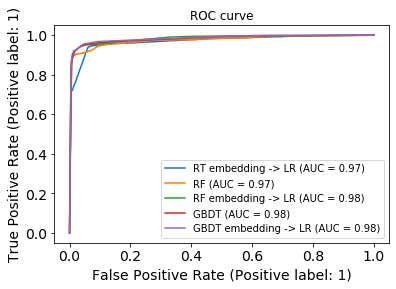

In [244]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots()

models = [
    ("RT embedding -> LR", rt_model),
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test, y_test, ax=ax, name=name)
_ = ax.set_title('ROC curve')

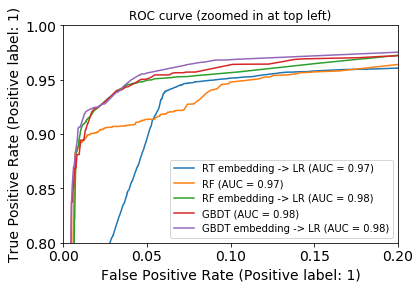

In [231]:
fig, ax = plt.subplots()
for name, pipeline in models:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title('ROC curve (zoomed in at top left)')

# 5. Boosting

boosting（最初称为 hypothesis boosting）是指将几个弱学习器（weak learner）组合成强学习器（strong learner）的任何集成方法。


**<font color='crimson'>大多数 boosting 方法的思想是，依次（sequentially）训练 predictor，每一次都对前一个 predictor 进行修正（correct）。</font>**



## 5.1 AdaBoost